<a href="https://colab.research.google.com/github/leedain0301/Data_MiniProject_02/blob/main/MiniProject_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 컬럼 설명

#   train.csv / test.csv <br>
>  : 서울 지역의 740,000여개 거래 데이터, 아파트 거래일, 지역, 전용면적, 실 거래가 등의 정보

- **features**
  *   transaction_id : 아파트 거래 유일키키
  *   apartment_id : 아파트 아이디
  *   city : 도시
  *   dong : 동
  *   jibun : 지번
  *   apt : 아파트단지 이름
  *   addr_kr : 주소
  *   exclusive_use_area : 전용면적
  *   year_of_completion : 설립일자
  *   transaction_year_month : 거래년월
  *   transaction_date : 거래날짜
  *   floor : 층
  *   transaction_real_price : 실거래가(train 만 존재)


#   park.csv<br>
>  : 서울 지역의 공원에 대한 정보

- **features**

  *  city : 도시 이름
  *  gu : 구
  *  dong : 동
  *  park_name : 공원 이름
  *  park_type : 공원 이름
  *  park_area : 공원의 넓이
  *  park_exercise_facility : 공원보유 운동시설
  *  park_entertainment_facility : 공원보유 유희시설
  *  park_benefit_facility : 공원보유 편익시설
  *  park_cultural_facitiy : 공원보유 교양시설
  *  park_facility_other : 공원보유 기타시설
  *  park_open_year : 공원 개장년도
  *  reference_date : 데이터 기준일자(해당 데이터가 기록된 일자)



<br>

---

<br>









In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import sklearn
from sklearn.linear_model    import ElasticNet, Lasso
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics         import mean_squared_error, accuracy_score

import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import sys

In [146]:
target = 'transaction_real_price'

train_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/test.csv')
submission_data = pd.read_csv('/content/drive/MyDrive/02.Colab Notebooks/MiniProject_02/submission.csv')

print('train.csv. Shape: ',train_data.shape)
print('test.csv. Shape: ', test_data.shape)

train.csv. Shape:  (1216553, 13)
test.csv. Shape:  (5463, 12)


In [161]:
# 서울/부산->부산 데이터 삭제
train_data.drop(train_data[(train_data['city'] == '부산광역시')].index, inplace=True)
test_data.drop(test_data[(test_data['city'] == '부산광역시')].index, inplace=True)

In [76]:
train_data.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500
3,3,10957,서울특별시,내수동,95,파크팰리스,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000
4,4,10639,서울특별시,내수동,110-15,킹스매너,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000


In [163]:
test_data.head()

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.55,2002,201711,11~20,2
3,1179897,11086,서울특별시,대치동,1007-2,풍림아이원4차(1007-2),대치동 1007-2 풍림아이원4차(1007-2),111.54,2004,201707,1~10,10
6,1151450,9179,서울특별시,염창동,254-2,이너스내안에,염창동 254-2 이너스내안에,84.91,2004,201711,1~10,13
7,1197195,4018,서울특별시,암사동,414-2,롯데캐슬퍼스트,암사동 414-2 롯데캐슬퍼스트,102.34,2008,201712,21~31,9
8,1146078,4397,서울특별시,신정동,311,목동신시가지10,신정동 311 목동신시가지10,106.06,1987,201712,11~20,4


In [164]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 742285 entries, 0 to 1184018
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   transaction_id          742285 non-null  int64  
 1   apartment_id            742285 non-null  int64  
 2   city                    742285 non-null  object 
 3   dong                    742285 non-null  object 
 4   jibun                   742285 non-null  object 
 5   apt                     742285 non-null  object 
 6   addr_kr                 742285 non-null  object 
 7   exclusive_use_area      742285 non-null  float64
 8   year_of_completion      742285 non-null  int64  
 9   transaction_year_month  742285 non-null  int64  
 10  transaction_date        742285 non-null  object 
 11  floor                   742285 non-null  int64  
 12  transaction_real_price  742285 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 95.4+ MB


In [165]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3911 entries, 0 to 5461
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          3911 non-null   int64  
 1   apartment_id            3911 non-null   int64  
 2   city                    3911 non-null   object 
 3   dong                    3911 non-null   object 
 4   jibun                   3911 non-null   object 
 5   apt                     3911 non-null   object 
 6   addr_kr                 3911 non-null   object 
 7   exclusive_use_area      3911 non-null   float64
 8   year_of_completion      3911 non-null   int64  
 9   transaction_year_month  3911 non-null   int64  
 10  transaction_date        3911 non-null   object 
 11  floor                   3911 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 397.2+ KB


In [166]:
train_data.duplicated().sum()

0

In [167]:
test_data.duplicated().sum()

0

In [168]:
train_null = train_data.drop('transaction_real_price', axis=1).isnull().sum()/len(train_data)*100
test_null = test_data.isnull().sum()/len(test_data)*100
pd.DataFrame({'train_null_count': train_null,'test_null_count':test_null})

,train_null_count,test_null_count
transaction_id,0.0,0.0
apartment_id,0.0,0.0
city,0.0,0.0
dong,0.0,0.0
jibun,0.0,0.0
apt,0.0,0.0
addr_kr,0.0,0.0
exclusive_use_area,0.0,0.0
year_of_completion,0.0,0.0
transaction_year_month,0.0,0.0


In [169]:
train_data.nunique()

transaction_id            742285
apartment_id                8251
city                           1
dong                         330
jibun                       6119
apt                         6917
addr_kr                     8251
exclusive_use_area         12475
year_of_completion            54
transaction_year_month       119
transaction_date               6
floor                         73
transaction_real_price     12301
dtype: int64

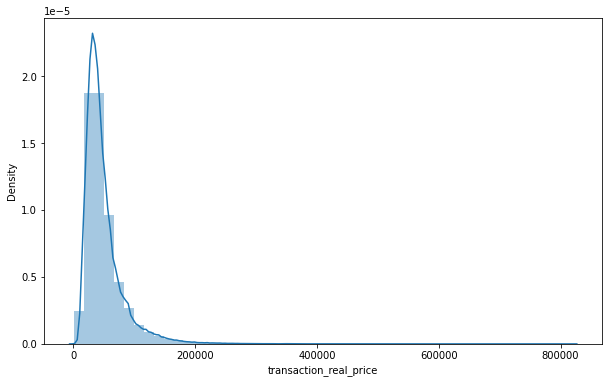

In [82]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

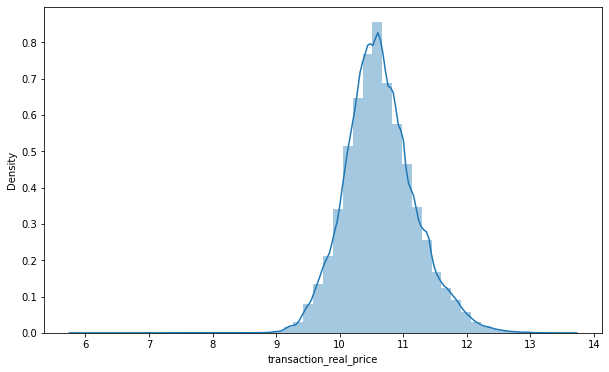

In [83]:
train_data['transaction_real_price'] = np.log1p(train_data['transaction_real_price'])
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(train_data['transaction_real_price'])

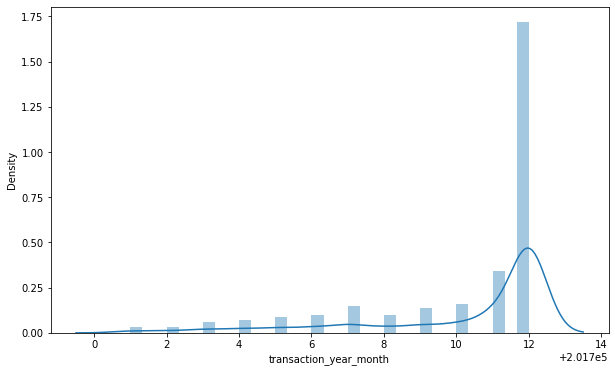

In [84]:
f,ax=plt.subplots(figsize=(10,6))
sns.distplot(test_data['transaction_year_month'])

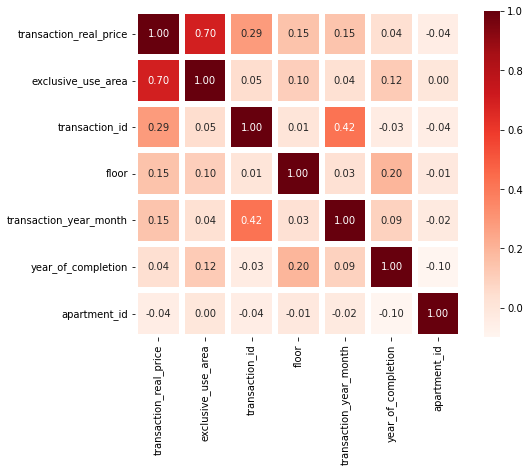

In [85]:
k = train_data.shape[1]
corrmat = train_data.corr()
cols = corrmat.nlargest(k,'transaction_real_price')['transaction_real_price'].index
cm = np.corrcoef(train_data[cols].values.T)
f,ax = plt.subplots(figsize=(8,6))
sns.heatmap(data=cm,
            annot = True,
            square=True,
            fmt='.2f',
            linewidths=5,
            cmap='Reds',
            yticklabels=cols.values,
            xticklabels=cols.values
            )

In [184]:
train_id = train_data['transaction_id']
train = train_data.drop('transaction_id',axis=1)
test_id = test_data['transaction_id']
test = test_data.drop('transaction_id',axis=1)

In [185]:
drop_columns=['apartment_id','apt','city','jibun','addr_kr']

train = train.drop(drop_columns,axis=1)
test = test.drop(drop_columns,axis=1)
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,신교동,84.82,2002,200801,21~31,2,37500
1,필운동,99.17,1973,200801,1~10,6,20000
2,필운동,84.74,2007,200801,1~10,6,38500
3,내수동,146.39,2003,200801,11~20,15,118000
4,내수동,194.43,2004,200801,21~31,3,120000


In [172]:
train_dong=train[['transaction_real_price','dong']].groupby('dong').mean().sort_values('transaction_real_price').reset_index()
train_dong.head()

,dong,transaction_real_price
0,장충동2가,6628.421053
1,필동1가,8466.666667
2,누상동,10650.000000
3,영등포동3가,11515.652174
4,영등포동2가,12402.040816


In [ ]:
dong_num={}
for i in range(len(train_dong)):
    dong=train_dong['dong'].iloc[i]
    dong_num[dong]=i
dong_num

In [186]:
train = train.replace({'dong': dong_num})
test = test.replace({'dong': dong_num})
train.head()

,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,192,84.82,2002,200801,21~31,2,37500
1,264,99.17,1973,200801,1~10,6,20000
2,264,84.74,2007,200801,1~10,6,38500
3,316,146.39,2003,200801,11~20,15,118000
4,316,194.43,2004,200801,21~31,3,120000


In [187]:
test.head()

,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,278,35.55,2002,201711,11~20,2
3,321,111.54,2004,201707,1~10,10
6,150,84.91,2004,201711,1~10,13
7,225,102.34,2008,201712,21~31,9
8,215,106.06,1987,201712,11~20,4


In [188]:
train[train['floor'] < 0] #오마이갓...지하가 있었어...

,dong,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
1656,178,140.040,2005,201109,1~10,-1,39000
2010,178,151.620,2005,201207,11~20,-1,40000
2220,127,59.760,1997,201302,11~20,-1,15800
2938,19,69.540,1997,201405,1~10,-1,17000
5071,222,59.990,2001,200801,11~20,-1,17000
...,...,...,...,...,...,...,...
1095416,323,212.524,2011,201705,21~31,-1,490000
1095417,323,212.524,2011,201705,21~31,-1,480000
1128345,226,134.480,2010,201704,1~10,-1,74000
1129887,226,134.510,2010,201711,11~20,-3,70500


floor->Skewness: 0.032724, Kurtosis: -0.670766


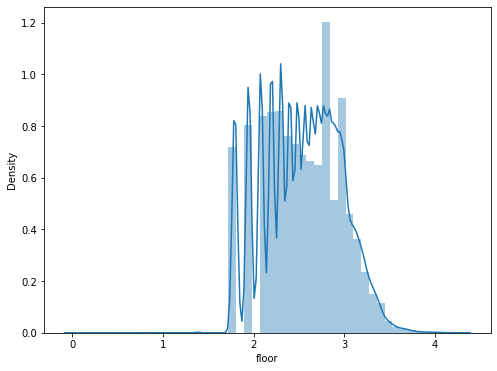

In [140]:
train['floor']=np.log(train['floor']+5)
test['floor']=np.log(test['floor']+5)
f,ax=plt.subplots(figsize=(8,6))
sns.distplot(train['floor'])
print("%s->Skewness: %f, Kurtosis: %f"%('floor',train['floor'].skew(),train['floor'].kurt()))

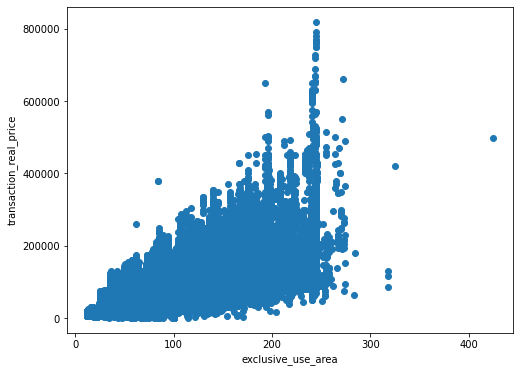

In [136]:
train['transaction_real_price'] = np.expm1(train_data['transaction_real_price'])

f,ax=plt.subplots(figsize=(8,6))
plt.scatter(train['exclusive_use_area'],train['transaction_real_price'])
plt.xlabel('exclusive_use_area')
plt.ylabel('transaction_real_price')
plt.show()

In [126]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


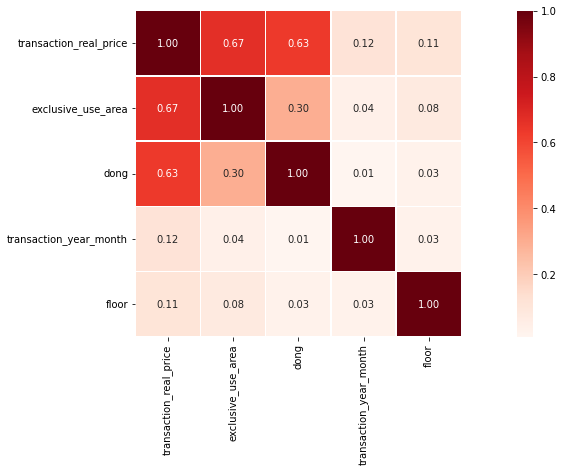

In [143]:
k = train.shape[1] 
corrmat = train.corr() 
cols = corrmat.nlargest(k, 'transaction_real_price')['transaction_real_price'].index 
cm = np.corrcoef(train[cols].values.T)
f, ax = plt.subplots(figsize = (20, 6))
sns.heatmap(data = cm, 
            annot=True, 
            square=True, 
            fmt = '.2f', 
            linewidths=.5, 
            cmap='Reds', 
            yticklabels = cols.values, 
            xticklabels = cols.values
            )

In [177]:
train, val = train_test_split(
    train, train_size=0.80, test_size=0.20,  random_state=2
)

train.shape, val.shape, test.shape

((593828, 5), (148457, 5), (3911, 4))

In [178]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [182]:
base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_acc = accuracy_score(y_train, baseline)
print(f'기준모델의 정확도는 {baseline_acc.round(2)} 입니다')

기준모델의 정확도는 0.01 입니다
